In [1]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import v2
import torch.optim as optim
from torchinfo import summary

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import xarray as xr
import random as rand
from pathlib import Path
import scipy
import skimage as ski
import torcheval
#import pytorch_lightning as pl

In [2]:
storm_filenames = os.listdir("../storm_pixels_data/")[1:]

storm_labels_dict = {}

for idx, ID in enumerate(storm_filenames):
    storm_labels_dict[idx] = ID[:-4]

In [3]:
#partition['train']
#storm_544_frame_2

In [4]:
#storm_labels_dict

In [5]:
#storm_labels_dict.values()
#storm_filenames

In [6]:
# storm_labels_dict.values()
#!ls ../../../a321/eeajl/storm_pixels_data

In [7]:
train_val_split = 1/3

val_size = int(np.floor(len(storm_labels_dict)*train_val_split))
train_size = int(len(storm_labels_dict) - val_size)
#print(test_size, train_size)

shuffled_labels = list(storm_labels_dict.values())
rand.shuffle(shuffled_labels)
train_labels = shuffled_labels[:val_size]
val_labels = shuffled_labels[val_size:]

partition = {"train":train_labels, "val":val_labels}

In [8]:
#storm_labels_dict[partition["train"][0]]

In [9]:
#partition["train"]

In [10]:
x = torch.zeros(10, 10)
t = torch.ones(10, 10)
#index = torch.tensor()

In [11]:
class RandomPad(object):
    """Pad the object up to a certain resolution placing the data pixels randomly within the box"""
    
    def __init__(self, output_res):
        assert isinstance(output_res, int)
        self.output_res = output_res
        self.threshold = 233
        
    def __call__(self, data):
        h, w = data.shape
        padded_data = np.ones((self.output_res, self.output_res))*self.threshold
        if (h<self.output_res) & (w<self.output_res):
            bl_corner_y, bl_corner_x = rand.randint(0, self.output_res-h), rand.randint(0, self.output_res-w)
            padded_data[bl_corner_y:bl_corner_y+h, bl_corner_x:bl_corner_x+w] = data
            padded_data = torch.from_numpy(padded_data)
            return padded_data
        
        else:
            #print(f"Error: Image too large at {h}x{w} pixels. Returning empty tensor")
            padded_data = torch.from_numpy(padded_data)
            return padded_data

class CentrePadAndNormalise(object):
    """Pad the object up to a certain resolution placing the data pixels randomly within the box"""
    
    def __init__(self, output_res):
        assert isinstance(output_res, int)
        self.output_res = output_res
        self.upper_threshold = 233
        self.lower_bound = 180
        
    def __call__(self, data, idx):
        # Normalise to between 0 (upper threshold K) and 1 (lower bound K) 
        data = (self.upper_threshold - data)/(self.upper_threshold-self.lower_bound)
        try:
            h, w = data.shape
        except ValueError:
            print(idx)
        padded_data = np.zeros((self.output_res, self.output_res))
        img_centre = np.floor(self.output_res/2)
        if (h<self.output_res) & (w<self.output_res):
            #bl_corner_y, bl_corner_x = rand.randint(0, self.output_res-h), rand.randint(0, self.output_res-w)
            padded_data[int(img_centre-np.floor(h/2)):int(img_centre+np.ceil(h/2)), int(img_centre-np.floor(w/2)):int(img_centre+np.ceil(w/2))] = data
            padded_data = torch.from_numpy(padded_data)
            return padded_data
        
        else:
            #print(f"Error: Image too large at {h}x{w} pixels. Returning empty tensor")
            padded_data = torch.from_numpy(padded_data)
            return padded_data

In [12]:
np.ceil(2.5)

np.float64(3.0)

In [13]:
class StormPixelsDataset(Dataset):
    """Storm Pixels dataset."""
    def __init__(self, list_IDs, transform=None):
        """
        Arguments:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = "../storm_pixels_data/"
        #self.labels = labels
        self.list_IDs = list_IDs
        #self.files = np_file_paths
        self.transform = transform

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, idx):
        ID = self.list_IDs[idx]
        
        #X = torch.from_numpy(np.float32(np.load(self.root_dir+ID+".npy")))
        #y = self.labels[ID]
        X = np.float32(np.load(self.root_dir+ID+".npy"))
        if self.transform:
            X = self.transform(X, idx)
        X = X.float()
        X = X.unsqueeze(0)
        #print(idx)
        
        return X, ID
        """
        print("Loading"+self.root_dir+"/"+self.files[idx])
        x = np.load(self.root_dir+"/"+self.files[idx])
        x = torch.from_numpy(x).float()
        return x
        """


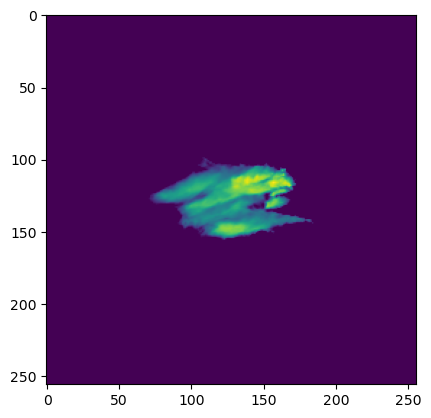

In [14]:
for i in range(0,2000):
    datafile = np.float32(np.load("../storm_pixels_data/"+storm_labels_dict[i]+".npy"))
datafile = np.float32(np.load("../storm_pixels_data/"+'storm_580_frame_6'+".npy"))
torchdata = torch.from_numpy(datafile)
output = CentrePadAndNormalise(256)(datafile, 0)
plt.imshow(output)

In [15]:
datafile.shape[:2]

(58, 114)

In [16]:
#partition = storm_labels_dict.values()
#labels = storm_labels_dict.keys()
#partition

In [17]:
#storm_pixels_dataset = StormPixelsDataset(storm_labels_dict)

In [18]:
#storm_pixels_dataset.list_IDs

In [19]:
#storm_pixels_dataset[1]

In [20]:
#train_set, val_set = torch.utils.data.random_split(storm_pixels_dataset, [test_size, train_size])

In [21]:
#plt.imshow(train_set[0], cmap='Greys')

In [22]:
#partition['train']

In [23]:
#trains_set = StormPixelsDataset(partition['train'])
#trains_set[100][0]

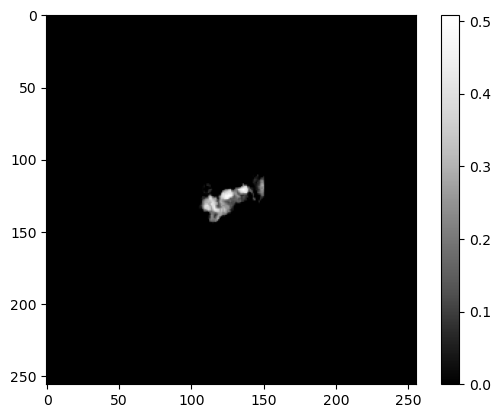

In [24]:
train_set = StormPixelsDataset(partition['train'], transform=CentrePadAndNormalise(256))
fig, ax = plt.subplots()
normpad = ax.imshow(train_set[0][0][0], cmap='Greys_r')
fig.colorbar(normpad)

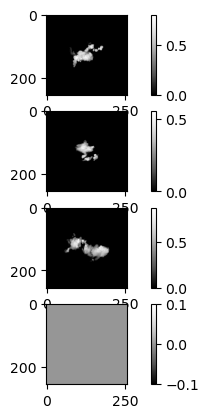

In [25]:
#idx = 0

idx = 1000
no_of_images = 4
fig, axs = plt.subplots(no_of_images)
train_set = StormPixelsDataset(partition['train'], transform=CentrePadAndNormalise(256))
val_set = StormPixelsDataset(partition['val'], transform=CentrePadAndNormalise(256))
for i in range(no_of_images):
    tensor_pad = axs[i].imshow(train_set[idx+i][0][0], cmap='Greys_r')
    fig.colorbar(tensor_pad)
    #tensor_pad.set_clim(vmax = 233)


In [26]:
train_set[0][0]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [27]:
#pad = RandomPad(512)
#output = pad(storm_pixels_dataset[0][0])
#plt.imshow(output[0])
#output

In [28]:
"""
pad = Random_pad(512)
print(len(train_set))
for i in range(len(train_set)):np.float32
    #print(i)
    output = pad(train_set[i])
plt.imshow(output, cmap='Greys')
"""

"\npad = Random_pad(512)\nprint(len(train_set))\nfor i in range(len(train_set)):np.float32\n    #print(i)\n    output = pad(train_set[i])\nplt.imshow(output, cmap='Greys')\n"

In [29]:
#random1 = torch.rand(2, 3)

In [30]:
#storm_pixels_dataset = StormPixelsDataset("../../../a321/eeajl/storm_pixels_data", storm_filenames)

In [31]:
#train_set, val_set = torch.utils.data.random_split(storm_pixels_dataset, [test_size, train_size])

In [32]:
#train_set[10]"""

In [33]:
#transforms.Resize(256)(storm_pixels_dataset[5])

In [34]:
#dataloader = DataLoader(storm_pixels_dataset, batch_size=64, shuffle=True)
#dataloader

In [35]:
#train_set, test_set = random_split(train_set)

In [36]:
#storm_pixels_dataset[1].shape

In [37]:
#fig, ax = plt.subplots()
#img = ax.imshow(storm_pixels_dataset[10], cmap='Greys')
#plt.colorbar(img)

In [38]:
class Print(nn.Module):
    def __init__(self):
        super(Print, self).__init__()
        
    def forward(self, x):
        print(x.shape)
        return x

In [39]:
# Define the CNN in PyTorch
class CNN_AE(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Build encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(64, 128, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(128, 128, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Build decoder
        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.ReLU(),
            # nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        """self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        """
    
    def forward(self, x):
        x = self.encoder(x)
        reduced_space = torch.flatten(x, 1)
        x = self.decoder(x)
        return x#, reduced_space

In [40]:
# Define the CNN in PyTorch
class CNN_AE(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Build encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(20, 20, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.1)
            # nn.Conv2d(64, 128, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(128, 128, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Build decoder
        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.ReLU(),
            # nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.ReLU(),
            nn.ConvTranspose2d(20, 20, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(20, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        """self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        """
    
    def forward(self, x):
        x = self.encoder(x)
        reduced_space = torch.flatten(x, 1)
        x = self.decoder(x)
        return x#, reduced_space

In [41]:
# Define the CNN in PyTorch
class CNN_VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Build encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(20, 20, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.1)
            # nn.Conv2d(64, 128, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(128, 128, kernel_size=3, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # Build decoder
        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.ReLU(),
            # nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.ReLU(),
            nn.ConvTranspose2d(20, 20, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(20, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        """self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        """
    
    def forward(self, x):
        x = self.encoder(x)
        reduced_space = torch.flatten(x, 1)
        x = self.decoder(x)
        return x#, reduced_space

In [42]:
model = CNN_AE()
print(model)

CNN_AE(
  (encoder): Sequential(
    (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.1, inplace=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(20, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(20, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)


In [43]:
model = CNN_AE()
batch_size = 64
summary(model, input_size=(batch_size, 1, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_AE                                   [64, 1, 256, 256]         --
├─Sequential: 1-1                        [64, 20, 64, 64]          --
│    └─Conv2d: 2-1                       [64, 20, 256, 256]        200
│    └─ReLU: 2-2                         [64, 20, 256, 256]        --
│    └─MaxPool2d: 2-3                    [64, 20, 128, 128]        --
│    └─Conv2d: 2-4                       [64, 20, 128, 128]        3,620
│    └─ReLU: 2-5                         [64, 20, 128, 128]        --
│    └─MaxPool2d: 2-6                    [64, 20, 64, 64]          --
│    └─Dropout: 2-7                      [64, 20, 64, 64]          --
├─Sequential: 1-2                        [64, 1, 256, 256]         --
│    └─ConvTranspose2d: 2-8              [64, 20, 128, 128]        3,620
│    └─ReLU: 2-9                         [64, 20, 128, 128]        --
│    └─ConvTranspose2d: 2-10             [64, 1, 256, 256]         181
│    └─

In [44]:
"""
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
"""

'\n# Define the loss function and optimizer\ncriterion = nn.MSELoss()\noptimizer = optim.Adam(model.parameters(), lr=0.001)\n'

In [45]:
"""
# Train the autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for data in storm_pixels_dataset:
        img = data
        #img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
"""

"\n# Train the autoencoder\nnum_epochs = 50\nfor epoch in range(num_epochs):\n    for data in storm_pixels_dataset:\n        img = data\n        #img = img.to(device)\n        optimizer.zero_grad()\n        output = model(img)\n        loss = criterion(output, img)\n        loss.backward()\n        optimizer.step()\n    if epoch % 5== 0:\n        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))\n"

In [46]:
"""
for data, labels in train_loader:
    print(data.shape)
    print(type(data))
"""

'\nfor data, labels in train_loader:\n    print(data.shape)\n    print(type(data))\n'

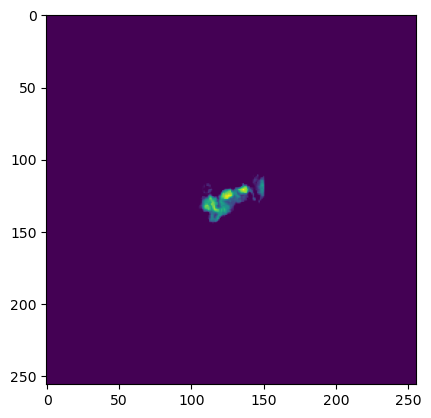

In [47]:
plt.imshow(train_set[0][0][0])

In [48]:
#train_set[:]
#print(inputs[0].shape)
#inputs

In [49]:
train_set[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'storm_544_frame_6')

In [50]:
"""
for epoch in range(max_epochs):
    # Training
    for local_batch, local_labels in train_loader:
        print(local_batch[0])
"""

'\nfor epoch in range(max_epochs):\n    # Training\n    for local_batch, local_labels in train_loader:\n        print(local_batch[0])\n'

In [51]:
"""
model = CNN_AE()
# Define transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
 
# Load dataset
train_dataset = datasets.Flowers102(root='flowers', 
                                    split='train', 
                                    transform=transform, 
                                    download=True)
test_dataset = datasets.Flowers102(root='flowers', 
                                   split='test', 
                                   transform=transform)
# Define the dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=128, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=128)
 
# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)
 
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
 
# Train the autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
 
# Save the model
torch.save(model.state_dict(), 'conv_autoencoder.pth')
"""

"\nmodel = CNN_AE()\n# Define transform\ntransform = transforms.Compose([\n    transforms.Resize((64, 64)),\n    transforms.ToTensor(),\n])\n \n# Load dataset\ntrain_dataset = datasets.Flowers102(root='flowers', \n                                    split='train', \n                                    transform=transform, \n                                    download=True)\ntest_dataset = datasets.Flowers102(root='flowers', \n                                   split='test', \n                                   transform=transform)\n# Define the dataloader\ntrain_loader = torch.utils.data.DataLoader(dataset=train_dataset, \n                                           batch_size=128, \n                                           shuffle=True)\ntest_loader = torch.utils.data.DataLoader(dataset=test_dataset, \n                                          batch_size=128)\n \n# Move the model to GPU\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\nprint(device)\nmodel.to(d

In [52]:
"""
model = CNN_AE()
print(model)

# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}

dataset = datasets.MNIST("data", download=True,
                 train=True, transform=transforms.ToTensor())
full_loader = torch.utils.data.DataLoader(dataset, shuffle=False, num_workers=os.cpu_count())
"""

'\nmodel = CNN_AE()\nprint(model)\n\n# Parameters\nparams = {\'batch_size\': 64,\n          \'shuffle\': True,\n          \'num_workers\': 6}\n\ndataset = datasets.MNIST("data", download=True,\n                 train=True, transform=transforms.ToTensor())\nfull_loader = torch.utils.data.DataLoader(dataset, shuffle=False, num_workers=os.cpu_count())\n'

In [53]:
"""
# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train autoencoder
max_epochs = 100
# Loop over epochs
for epoch in range(max_epochs):
    # Training
    for local_batch, local_labels in full_loader:
        #print(local_batch, local_labels)
        # Transfer to GPU
        local_batch = local_batch[:-1].to(device)
        optimizer.zero_grad()
        output = model(local_batch)
        loss = criterion(output, local_batch)
        loss.backward()
        optimizer.step()
        #print(local_batch)
        #print(output)
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, max_epochs, loss.item()))
"""

"\n# Move the model to GPU\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\nprint(device)\nmodel.to(device)\n\n# Define the loss function and optimizer\ncriterion = nn.MSELoss()\noptimizer = optim.Adam(model.parameters(), lr=0.001)\n\n# Train autoencoder\nmax_epochs = 100\n# Loop over epochs\nfor epoch in range(max_epochs):\n    # Training\n    for local_batch, local_labels in full_loader:\n        #print(local_batch, local_labels)\n        # Transfer to GPU\n        local_batch = local_batch[:-1].to(device)\n        optimizer.zero_grad()\n        output = model(local_batch)\n        loss = criterion(output, local_batch)\n        loss.backward()\n        optimizer.step()\n        #print(local_batch)\n        #print(output)\n    if epoch % 5== 0:\n        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, max_epochs, loss.item()))\n"

In [54]:
"""
N_CHANNELS = 1

mean = torch.zeros(1)
std = torch.zeros(1)
print('==> Computing mean and std..')
for inputs, _labels in train_loader:
        #print(inputs[:,i,:,:])
    inputs = inputs[:-1]
    mean = inputs.mean()
    std = inputs.std()
mean.div_(len(train_set))
std.div_(len(train_set))
#print(inputs[0].mean())
"""

"\nN_CHANNELS = 1\n\nmean = torch.zeros(1)\nstd = torch.zeros(1)\nprint('==> Computing mean and std..')\nfor inputs, _labels in train_loader:\n        #print(inputs[:,i,:,:])\n    inputs = inputs[:-1]\n    mean = inputs.mean()\n    std = inputs.std()\nmean.div_(len(train_set))\nstd.div_(len(train_set))\n#print(inputs[0].mean())\n"

In [55]:
model = CNN_AE()
print(model)

# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}

# Datasets
#partition = storm_labels_dict.values()
#labels = storm_labels_dict.keys()

# Generators
train_set = StormPixelsDataset(partition['train'], transform=CentrePadAndNormalise(256))
train_loader = torch.utils.data.DataLoader(train_set, **params)

val_set = StormPixelsDataset(partition['val'], transform=CentrePadAndNormalise(256))
val_loader = torch.utils.data.DataLoader(val_set, **params)

# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train autoencoder
max_epochs = 20
# Loop over epochs
loss_over_time = []
for epoch in range(max_epochs):
    # Training
    for local_batch, local_labels in train_loader:
        #print(local_batch, local_labels)
        # Transfer to GPU
        local_batch = local_batch[:-1].to(device)
        optimizer.zero_grad()
        output = model(local_batch)
        loss = criterion(output, local_batch)
        loss.backward()
        optimizer.step()
        #print(local_batch)
        #print(output)
    for local_val_batch, local_val_labels in val_loader:
        local_val_vatch = local_val_batch = local_val_batch[:-1].to(device)
        val_output = model(local_val_batch)
        val_loss = criterion(val_output, local_val_batch)
    loss_over_time.append([epoch, loss, val_loss])
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, max_epochs, loss.item()))

CNN_AE(
  (encoder): Sequential(
    (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.1, inplace=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(20, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(20, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)
cpu
Epoch [1/20], Loss: 0.0014
Epoch [6/20], Loss: 0.0002
Epoch [11/20], Loss: 0.0001
Epoch [16/20], Loss: 0.0001


In [61]:
loss_over_time
loss_arr = np.empty((len(loss_over_time), 3))
for i in range(len(loss_over_time)):
    loss_arr[i] = loss_over_time[i][0], loss_over_time[i][1].detach().numpy(), loss_over_time[i][2].detach().numpy()    

In [62]:
loss_arr

array([[0.00000000e+00, 2.83966959e-03, 2.09496007e-03],
       [1.00000000e+00, 9.75512317e-04, 7.94168329e-04],
       [2.00000000e+00, 5.39751898e-04, 4.08135907e-04],
       [3.00000000e+00, 4.22457670e-04, 4.17295756e-04],
       [4.00000000e+00, 2.98004888e-04, 3.10629635e-04],
       [5.00000000e+00, 2.94710451e-04, 2.81686516e-04],
       [6.00000000e+00, 2.48661032e-04, 2.08837926e-04],
       [7.00000000e+00, 1.75397843e-04, 2.18217800e-04],
       [8.00000000e+00, 2.44072289e-04, 1.77891998e-04],
       [9.00000000e+00, 2.64737377e-04, 1.46721592e-04],
       [1.00000000e+01, 2.35707455e-04, 2.08364581e-04],
       [1.10000000e+01, 1.57387840e-04, 1.33616559e-04],
       [1.20000000e+01, 1.99082468e-04, 1.38131436e-04],
       [1.30000000e+01, 1.00749356e-04, 1.29349093e-04],
       [1.40000000e+01, 1.11463451e-04, 1.43655998e-04],
       [1.50000000e+01, 1.28068932e-04, 1.30885732e-04],
       [1.60000000e+01, 1.04475424e-04, 1.82162767e-04],
       [1.70000000e+01, 1.24153

In [63]:
#arr = np.hstack(loss_over_time.detach().numpy())

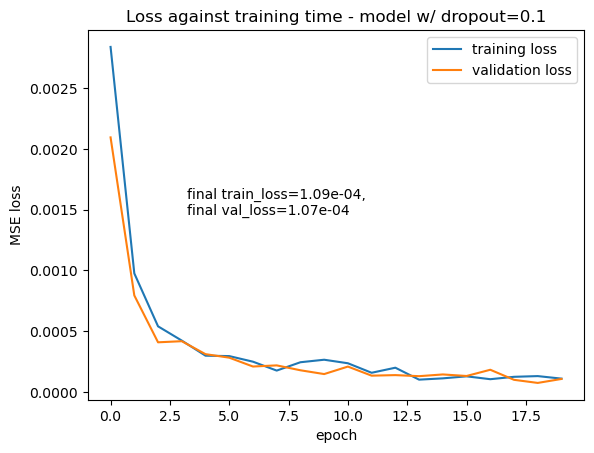

In [64]:
fig, ax = plt.subplots()
ax.set_title("Loss against training time - model w/ dropout=0.1")
#ax.set_title("Loss against training time - model w/o dropout")
ax.plot(loss_arr[:,0], loss_arr[:,1], label='training loss')
ax.plot(loss_arr[:,0], loss_arr[:,2], label='validation loss')
ax.set_xlabel("epoch")
ax.set_ylabel("MSE loss")
ax.text(0.2, 0.5, f"final train_loss={loss_arr[-1,1]:.2e},\nfinal val_loss={loss_arr[-1,2]:.2e}", transform=ax.transAxes)
ax.legend()
#plt.savefig("Loss-dropout=0.1.png")

In [65]:
partition['train'][1241]

'storm_375_frame_0'

In [66]:
val_set[0]
for val_batch, val_labels in val_loader:
    val_batch = val_batch[:-1]
    val_image = val_batch[0]

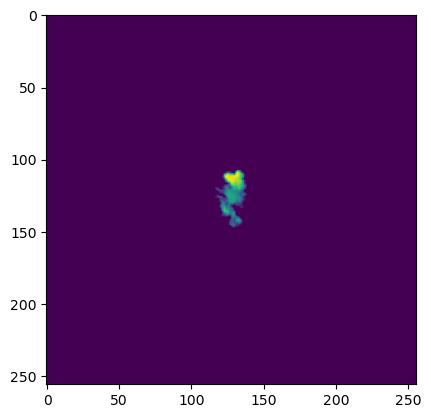

In [67]:
plt.imshow(val_image[0])

In [68]:
#val_batch.detach().numpy()


In [84]:
for storm_no in range(len(val_batch)):
    from torcheval.metrics import R2Score
    metric = R2Score(multioutput="uniform_average")
    target = val_batch[storm_no][0]
    input_dat = model(val_batch)[storm_no][0]
    #target = val_batch.detach().numpy()
    #input_dat = model(val_batch).detach().numpy()
    #metric(input, target)
    metric.update(input_dat, target)
    metric.compute()
    print(1 - np.var(input_dat.detach().numpy()-target.detach().numpy())/np.var(target.detach().numpy()))

0.9537524
0.9298158
0.98308104
0.98899126
0.9701936
0.97855246
0.9084769
0.914474
0.96947604
0.95891786
0.97891724
0.96062845


/tmp/ipykernel_70940/1263292230.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  print(1 - np.var(input_dat.detach().numpy()-target.detach().numpy())/np.var(target.detach().numpy()))


-inf
0.9590878
0.95104533
0.95968384
0.91464114
0.96966976
-inf
0.9725333
0.94518054
0.9523159
0.9781096
0.9395071
0.9417132
0.95205224
0.92782414
0.97136617
0.98910123
0.96025765
0.94022375
0.95927274
0.93994063
0.96185356
0.9506385
0.9348948
0.95330924
0.98791295
0.92534196
0.95192266
0.97710234
0.9858904
0.96361756
0.9815531
0.96242344
0.96376115
0.9791817


In [ ]:
storm_no = 10
dat = model(local_batch)[storm_no][0]
fig, axs = plt.subplots(2, figsize=(20,20))
axs[0].imshow(local_batch[storm_no][0].detach().numpy())
axs[1].imshow(dat.detach().numpy())
#plt.savefig("data vs output (train data) dropout=0.1.png")

In [ ]:
storm_no = 0
val = model(val_batch)[storm_no][0]
fig, axs = plt.subplots(2, figsize=(20,20))
axs[0].imshow(val_batch[storm_no][0].detach().numpy())
axs[1].imshow(val.detach().numpy())
val_loss = criterion(val, local_val_batch[storm_no][0])
print(val_loss)
#plt.savefig("data vs output (val data) dropout=0.1.png")

In [ ]:
output.size()
#model
model.state_dict()

In [295]:
upper_threshold = 233
lower_bound = 180
input_imgs = []
output_imgs = []
for storm_no in range(len(val_batch)):
    input_img = val_batch[storm_no][0].detach().numpy()
    val = model(val_batch)[storm_no][0]
    output_img = val.detach().numpy()
    rescaled_output_img = upper_threshold - (upper_threshold-lower_bound)*output_img
    rescaled_input_img = upper_threshold - (upper_threshold-lower_bound)*input_img
    input_imgs.append(rescaled_input_img)
    output_imgs.append(rescaled_output_img)
    #print(rescaled_output_img)

In [438]:
print(len(input_imgs))
idx = 31
input_img = input_imgs[idx]
output_img = output_imgs[idx]

47


In [439]:
input_binary = input_img < 232.9
input_attr = ski.measure.regionprops(input_binary.astype(np.uint8), intensity_image=input_img)

output_binary = output_img < 232.9
labelled_regions = ski.measure.label(output_binary)
area_max = 0
label_of_largest_region = 0
for label, region in enumerate(ski.measure.regionprops(ski.measure.label(output_binary))):
    if region.area > area_max:
        area_max = region.area
        label_of_largest_region = label
#ski.measure.regionprops(ski.measure.label(output_binary))[label_of_largest_region].area
biggest_region_only = np.where(labelled_regions == label_of_largest_region+1, 1, 0)
output_attr = ski.measure.regionprops(biggest_region_only.astype(np.uint8), intensity_image=output_img)
#for attr in output_attr[0]:
#    print(f"{attr}: {str(input_attr[0][attr])} vs. {str(output_attr[0][attr])}")

In [440]:
#plt.imshow(ski.measure.label(output_binary))
labelled_regions = ski.measure.label(output_binary)
area_max = 0
label_of_largest_region = 0
for label, region in enumerate(ski.measure.regionprops(ski.measure.label(output_binary))):
    if region.area > area_max:
        area_max = region.area
        label_of_largest_region = label
ski.measure.regionprops(ski.measure.label(output_binary))[label_of_largest_region].area
biggest_region_only = np.where(labelled_regions == label_of_largest_region+1, 1, 0)
#plt.imshow(input_binary.astype(np.uint8))
#plt.imshow(biggest_region_only, alpha=0.3)
output_img_largest_region_thresholded = np.multiply(biggest_region_only, output_img)
output_img_largest_region_thresholded = np.where(output_img_largest_region_thresholded != 0, output_img_largest_region_thresholded, 233)
#plt.imshow(output_img_largest_region_thresholded, cmap='Greys')

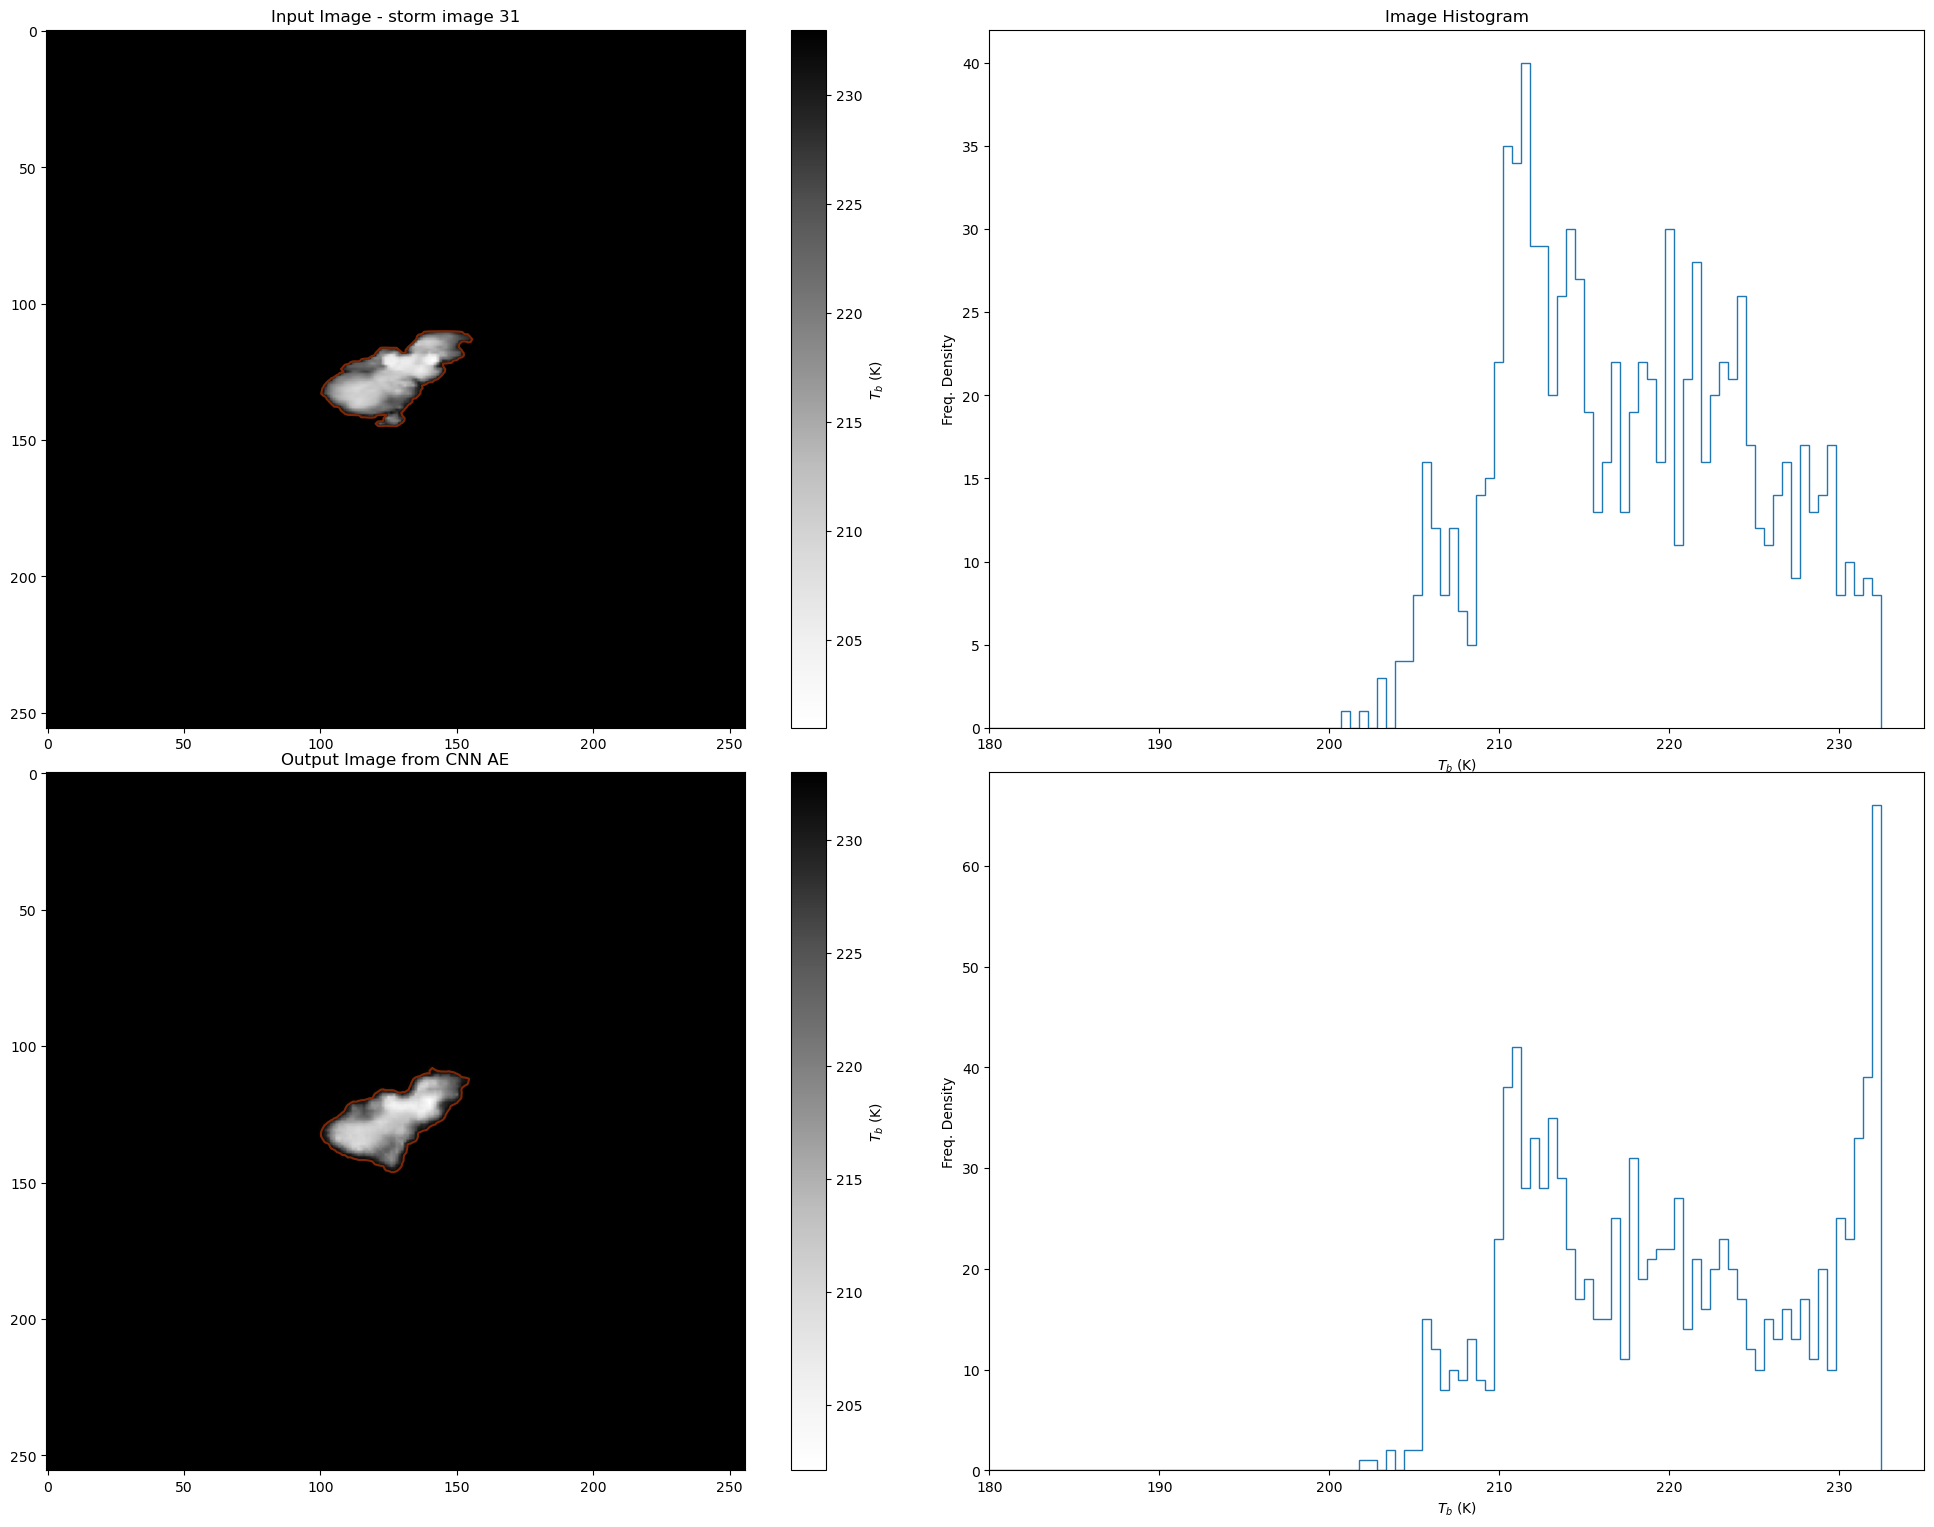

In [441]:
fig, axs = plt.subplots(2,2, figsize=(20, 15))
plt.tight_layout()
input_vis = axs[0, 0].imshow(input_img, cmap='Greys')
axs[0,0].contour(input_img, levels=[232, 233], cmap='Oranges_r')
#axs[1, 0].imshow(output_img_largest_region_thresholded, cmap='Reds')
output_vis = axs[1, 0].imshow(output_img_largest_region_thresholded, cmap='Greys')
axs[1,0].contour(output_img_largest_region_thresholded, levels=[232, 233], cmap='Oranges_r')
axs[0, 0].set_title(f"Input Image - storm image {idx}")
axs[1, 0].set_title("Output Image from CNN AE")
fig.colorbar(input_vis, label=r"$T_b$ (K)")
fig.colorbar(output_vis, label=r"$T_b$ (K)")

input_counts, input_bins = np.histogram(input_img.ravel(), bins=100, range=(180, 233))
axs[0, 1].stairs(input_counts[:-1], input_bins[:-1])
axs[0, 1].set_xlim(180, 235)
axs[0, 1].set_title(r"Image Histogram")
axs[0, 1].set_xlabel(r"$T_b$ (K)")
axs[0, 1].set_ylabel("Freq. Density")

output_counts, output_bins = np.histogram(output_img_largest_region_thresholded.ravel(), bins=100, range=(180, 233))
axs[1, 1].stairs(output_counts[:-1], output_bins[:-1])
axs[1, 1].set_xlim(180, 235)
#axs[1, 1].set_title(r"Output Image $T_b$ histogram")
axs[1, 1].set_xlabel(r"$T_b$ (K)")
axs[1, 1].set_ylabel("Freq. Density")
plt.savefig(f"storm pixel statistics input vs output for storm image {idx}.png")

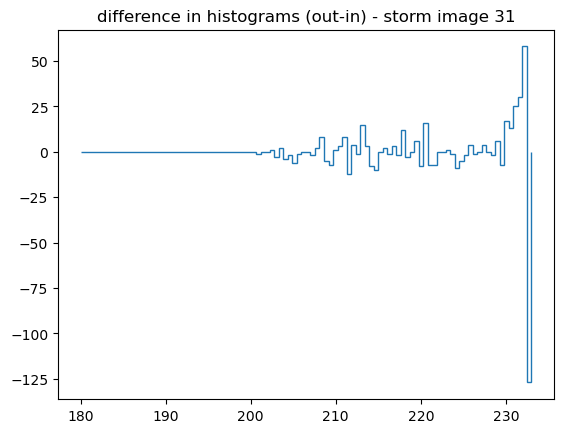

In [442]:
fig, ax = plt.subplots()
ax.stairs((output_counts - input_counts), input_bins)
#ax.stairs((output_counts[:-1] - input_counts[:-1]), input_bins[:-1])
#ax.stairs((output_counts - input_counts)[:-1]/input_counts[:-1], input_bins[:-1])
ax.set_title(f"difference in histograms (out-in) - storm image {idx}")
plt.savefig(f"storm pixel statistics anomaly {idx}.png")

(180.0, 235.0)

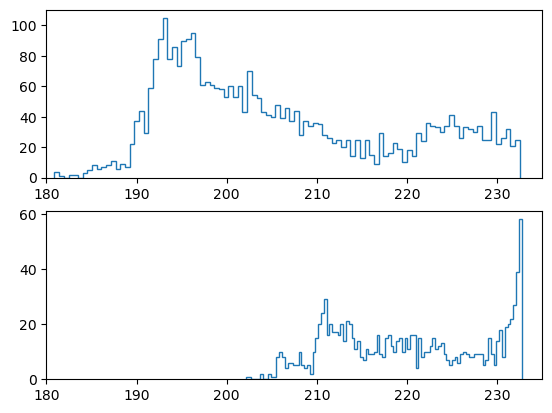

In [443]:
fig, axs = plt.subplots(2)

input_counts, input_bins = np.histogram(rescaled_input_img.ravel(), bins=100)
axs[0].stairs(input_counts[:-1], input_bins[:-1])
axs[0].set_xlim(180, 235)

output_counts, output_bins = np.histogram(output_img_largest_region_thresholded.ravel(), bins=100)
axs[1].stairs(output_counts[:-1], output_bins[:-1])
axs[1].set_xlim(180, 235)

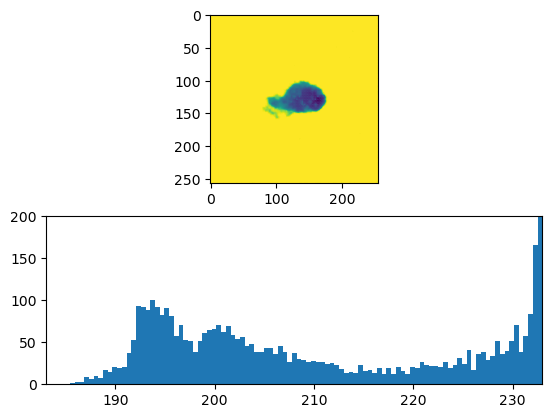

In [444]:
#ski.measure.regionprops(rescaled_output_img)
binary = rescaled_output_img < 232
fig, axs = plt.subplots(2)
axs[1].hist(rescaled_output_img.ravel(), bins=100)
axs[1].set_xlim(left=None, right=233)
axs[1].set_ylim(bottom=None, top=200)
axs[0].imshow(rescaled_output_img)

In [447]:
inputs_counts = np.empty((len(input_imgs), 100))
outputs_counts = np.empty((len(output_imgs), 100))
for idx in range(len(input_imgs)):
    input_img = input_imgs[idx]
    output_img = output_imgs[idx]
    
    input_binary = input_img < 232.9
    input_attr = ski.measure.regionprops(input_binary.astype(np.uint8), intensity_image=input_img)
    
    output_binary = output_img < 232.9
    labelled_regions = ski.measure.label(output_binary)
    area_max = 0
    label_of_largest_region = 0
    for label, region in enumerate(ski.measure.regionprops(ski.measure.label(output_binary))):
        if region.area > area_max:
            area_max = region.area
            label_of_largest_region = label
    #ski.measure.regionprops(ski.measure.label(output_binary))[label_of_largest_region].area
    biggest_region_only = np.where(labelled_regions == label_of_largest_region+1, 1, 0)
    output_attr = ski.measure.regionprops(biggest_region_only.astype(np.uint8), intensity_image=output_img)
    #for attr in output_attr[0]:
    #    print(f"{attr}: {str(input_attr[0][attr])} vs. {str(output_attr[0][attr])}")
    
    #plt.imshow(ski.measure.label(output_binary))
    labelled_regions = ski.measure.label(output_binary)
    area_max = 0
    label_of_largest_region = 0
    for label, region in enumerate(ski.measure.regionprops(ski.measure.label(output_binary))):
        if region.area > area_max:
            area_max = region.area
            label_of_largest_region = label
    ski.measure.regionprops(ski.measure.label(output_binary))[label_of_largest_region].area
    biggest_region_only = np.where(labelled_regions == label_of_largest_region+1, 1, 0)
    #plt.imshow(input_binary.astype(np.uint8))
    #plt.imshow(biggest_region_only, alpha=0.3)
    output_img_largest_region_thresholded = np.multiply(biggest_region_only, output_img)
    output_img_largest_region_thresholded = np.where(output_img_largest_region_thresholded != 0, output_img_largest_region_thresholded, 233)
    #plt.imshow(output_img_largest_region_thresholded, cmap='Greys')

    input_counts, input_bins = np.histogram(input_img.ravel(), bins=100, range=(180, 233))
    output_counts, output_bins = np.histogram(output_img_largest_region_thresholded.ravel(), bins=100, range=(180, 233))
    inputs_counts[idx] = input_counts
    outputs_counts[idx] = output_counts
    

Text(0, 0.5, 'Freq. Density')

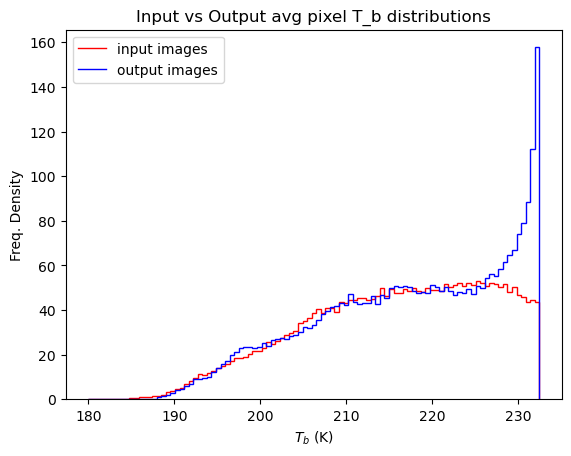

In [475]:
mean_input_counts = np.mean(inputs_counts, axis=0)
std_input_counts = np.std(inputs_counts, axis=0)
mean_output_counts = np.mean(outputs_counts, axis=0)
std_output_counts = np.std(outputs_counts, axis=0)
plt.stairs(mean_input_counts[:-1], input_bins[:-1], label="input images", color='red')
#plt.stairs((mean_input_counts - std_input_counts)[:-1], input_bins[:-1], label="std dev input", color='purple')
#plt.stairs((mean_input_counts + std_input_counts)[:-1], input_bins[:-1], label="std dev input", color='purple')
plt.stairs(mean_output_counts[:-1], output_bins[:-1], label="output images", color='blue')
#plt.stairs((mean_input_counts - std_output_counts)[:-1], input_bins[:-1], label="std dev input", color='blue')
#plt.stairs((mean_input_counts + std_output_counts)[:-1], input_bins[:-1], label="std dev input", color='blue')
plt.legend()
plt.title("Input vs Output avg pixel T_b distributions")
plt.xlabel(r"$T_b$ (K)")
plt.ylabel("Freq. Density")

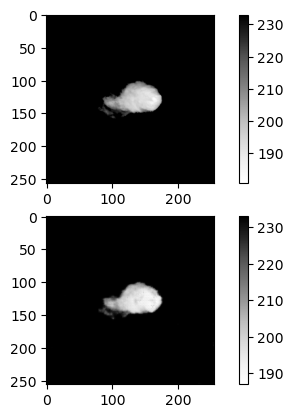

In [81]:
fig, axs = plt.subplots(2)
input_plt = axs[0].imshow(rescaled_input_img, cmap='Greys')
output_plt = axs[1].imshow(rescaled_output_img, cmap="Greys")
fig.colorbar(input_plt)
fig.colorbar(output_plt)

[[232.99455 232.99452 232.99814 ... 232.9773  232.9725  232.6666 ]
 [232.9921  232.99586 232.99916 ... 232.98352 232.97514 232.83086]
 [232.99918 232.9992  232.99982 ... 232.99577 232.99461 232.73122]
 ...
 [232.9724  232.96245 232.99133 ... 232.87128 232.74524 232.28586]
 [232.99062 232.98705 232.99675 ... 232.87773 232.88777 231.15518]
 [232.84555 232.92535 232.88483 ... 232.53778 231.61978 231.4114 ]]
[[232.97551 232.97617 232.98573 ... 232.92683 232.8989  232.21733]
 [232.96658 232.98083 232.99188 ... 232.96544 232.94904 232.64127]
 [232.99377 232.9933  232.99759 ... 232.9898  232.99261 232.6837 ]
 ...
 [232.93835 232.95801 232.99437 ... 232.93465 232.8828  232.63936]
 [232.98248 232.98181 232.99628 ... 232.95502 232.9513  231.80962]
 [232.79364 232.90729 232.89435 ... 232.79347 232.17493 232.1299 ]]
[[232.94733 232.95929 232.98404 ... 232.95856 232.96143 232.60287]
 [232.92917 232.96408 232.98946 ... 232.96992 232.97244 232.80391]
 [232.98657 232.99004 232.99622 ... 232.9954  232.

In [107]:
#torch.save(model.state_dict(), "model_dropout=0.1")

In [110]:
model_load = CNN_AE()
model_load.load_state_dict(torch.load("model_dropout=0.1"))
model_load.eval()

/tmp/ipykernel_428440/941112447.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_load.load_state_dict(torch.load("model_dropout=0.1"))


CNN_AE(
  (encoder): Sequential(
    (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.1, inplace=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(20, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(20, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)

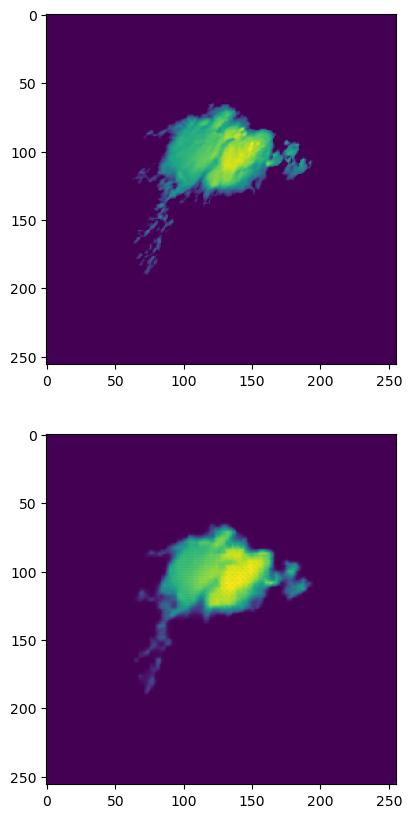

In [118]:
#model_load
storm_no = 15
fig, axs = plt.subplots(2, figsize=(10,10))
axs[0].imshow(local_batch[storm_no][0].detach().numpy())
axs[1].imshow(model_load(local_batch)[storm_no][0].detach().numpy())

In [191]:
class VAE(nn.Module):

    input_dim = 1024
    hidden_dim = 512
    latent_dim = 100
    def __init__(self, input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2D(input_dim, hidden_dim, 128, stride=1, padding=0),
            nn.LeakyReLU(0.2),
            nn.Conv2D(hidden_dim, latent_dim, 64, stride=1, padding=0),
            nn.LeakyReLU(0.2)
            )
        
        """
        # latent mean and variance 
        self.latent_layer = nn.Conv(latent_dim, 2, 16)
        """
        
        # decoder
        self.decoder = nn.Sequential(model = ConvNet()
batch_size = 16
summary(model, input_size=(batch_size, 1, 28, 28))
            nn.Conv2D(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Conv2D(latent_dim, hidden_dim, 64, stride=1, padding=0),
            nn.LeakyReLU(0.2),
            nn.Conv2D(hidden_dim, input_dim, 128, stride=1, padding=0),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [170]:
#dropout_loss_arr_20 = loss_arr
#no_dropout_loss_arr = loss_arr

In [179]:
#np.save("dropout_loss_arr_20.npy", dropout_loss_arr_20)
#np.save("no_dropout_loss_arr.npy", no_dropout_loss_arr)

In [173]:
dropout_loss_arr_20

array([[0.00000000e+00, 7.97530822e-03, 6.58359425e-03],
       [1.00000000e+00, 1.38826680e-03, 1.48344773e-03],
       [2.00000000e+00, 1.11795834e-03, 9.48515430e-04],
       [3.00000000e+00, 5.89005707e-04, 6.04610133e-04],
       [4.00000000e+00, 4.04489343e-04, 6.08185132e-04],
       [5.00000000e+00, 5.35945350e-04, 5.07340650e-04],
       [6.00000000e+00, 2.51915742e-04, 4.55590372e-04],
       [7.00000000e+00, 3.37124395e-04, 3.97645723e-04],
       [8.00000000e+00, 3.96947667e-04, 3.36019351e-04],
       [9.00000000e+00, 2.73132813e-04, 3.27594171e-04],
       [1.00000000e+01, 2.50409823e-04, 4.70132189e-04],
       [1.10000000e+01, 3.17182014e-04, 3.55242140e-04],
       [1.20000000e+01, 4.22335841e-04, 3.19703569e-04],
       [1.30000000e+01, 2.37791231e-04, 3.01347143e-04],
       [1.40000000e+01, 1.79712195e-04, 3.57126031e-04],
       [1.50000000e+01, 4.27083636e-04, 3.06740258e-04],
       [1.60000000e+01, 2.59038701e-04, 2.19153881e-04],
       [1.70000000e+01, 2.96304

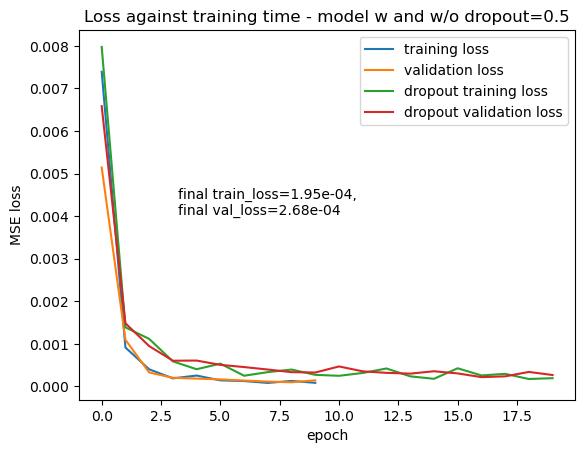

In [176]:
fig, ax = plt.subplots()
ax.set_title("Loss against training time - model w and w/o dropout=0.5")
#ax.set_title("Loss against training time - model w/o dropout")
ax.plot(no_dropout_loss_arr[:,0], no_dropout_loss_arr[:,1], label='training loss')
ax.plot(no_dropout_loss_arr[:,0], no_dropout_loss_arr[:,2], label='validation loss')
ax.plot(dropout_loss_arr_20[:,0], dropout_loss_arr_20[:,1], label='dropout training loss')
ax.plot(dropout_loss_arr_20[:,0], dropout_loss_arr_20[:,2], label='dropout validation loss')
ax.set_xlabel("epoch")
ax.set_ylabel("MSE loss")
ax.text(0.2, 0.5, f"final train_loss={loss_arr[-1,1]:.2e},\nfinal val_loss={loss_arr[-1,2]:.2e}", transform=ax.transAxes)
ax.legend()
plt.savefig("Loss-dropout vs non-dropout.png")